### Example: Predicting Bicycle Traffic

• As an example, let's take a look at whether we can predict the number of bicycle trips across Seattle's Fremont Bridge based on weather, season, and other factors.

• We have seen this data already in Working With Time Series.

• In this section, we will join the bike data with another dataset, and try to determine the extent to which weather and seasonal factors—temperature, precipitation, and daylight hours—affect the volume of bicycle traffic through this corridor.

• Fortunately, the NOAA makes available their daily weather station data (I used station ID USW00024233) and we can easily use Pandas to join the two data sources.

• We will perform a simple linear regression to relate weather and other information to bicycle counts, in order to estimate how a change in any one of these parameters affects the number of riders on a given day.

• In particular, this is an example of how the tools of Scikit-Learn can be used in a statistical modeling framework, in which the parameters of the model are assumed to have interpretable meaning.

• As discussed previously, this is not a standard approach within machine learning, but such interpretation is possible for some models.

• Let's start by loading the two datasets, indexing by date:

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.linear_model import LinearRegression

In [77]:
counts = pd.read_csv('Bicycle_Counts.csv', index_col = 'Date', parse_dates = True)
weather = pd.read_csv('Bicycle_Weather.csv', index_col = 'DATE', parse_dates = True)

• Next we will compute the total daily bicycle traffic, and put this in its own dataframe:

In [78]:
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis = 1)
daily = daily[['Total']] # Remove other colomns
daily.head()

,Total
Date,
2012-10-03,3521.0
2012-10-04,3475.0
2012-10-05,3148.0
2012-10-06,2006.0
2012-10-07,2142.0


• We saw previously that the patterns of use generally vary from day to day; let's account for this in our data by adding binary columns that indicate the day of the week:

In [79]:
days = ['Mon', 'Tue', 'Wed', 'Thu','Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

• Similarly, we might expect riders to behave differently on holidays; let's add an indicator of this as well:

In [80]:
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index = holidays, name = 'holidays'), lsuffix='_a', rsuffix='_b')
daily['holidays'].fillna(0, inplace = True)

• We also might suspect that the hours of daylight would affect how many people ride; let's use the standard astronomical calculation to add this information:

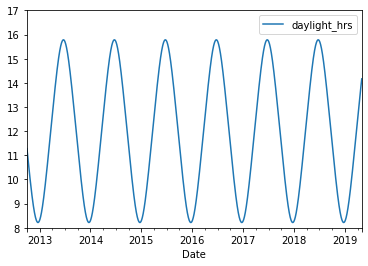

In [81]:
def hours_of_daylight(date, axis = 23.44, latitude = 47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
                   * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.
daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17);

• We can also add the average temperature and total precipitation to the data.

• In addition to the inches of precipitation, let's add a flag that indicates whether a day is dry (has zero precipitation):

In [82]:
# temperatures are in 1/10 deg C; Convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp(C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# Precip is in 1/10mm; Convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp(C)', 'dry day']], lsuffix='_a', rsuffix='_b')
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holidays,daylight_hrs,PRCP,Temp(C),dry day
Date,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0


• Finally, let's add a counter that increases from day 1, and measures how many years have passed.

• This will let us measure any observed annual increase or decrease in daily crossings:

In [83]:
daily['annual'] = (daily.index - daily.index[0]).days / 365

• Now our data is in order, and we can take a look at it:

In [85]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holidays,daylight_hrs,PRCP,Temp(C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0,0.000000
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0,0.002740
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0,0.005479
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0,0.008219
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0,0.010959


• With this in place, we can choose the columns to use, and fit a linear regression model to our data.

• We will set fit_intercept = False, because the daily flags essentially operate as their own day-specific intercepts:

In [86]:
daily.shape

(2401, 14)

In [92]:
# Drop any rows with null values
daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holidays',
               'daylight_hrs', 'PRCP', 'dry day', 'Temp(C)', 'annual']

X = daily[column_names]
y = daily['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

• Finally, we can compare the total and predicted bicycle traffic visually:

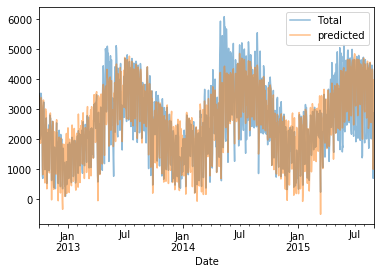

In [94]:
daily[['Total', 'predicted']].plot(alpha = 0.5);